In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import powerlaw
import csv
from collections import Counter
from scipy.ndimage import label, find_objects
from scipy.ndimage import label, generate_binary_structure
from scipy.ndimage.measurements import find_objects
from scipy.ndimage.morphology import binary_dilation
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

C:\Users\alexk\AppData\Local\Temp\ipykernel_25256\2432886602.py:10: DeprecationWarning: Please use `find_objects` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import find_objects
C:\Users\alexk\AppData\Local\Temp\ipykernel_25256\2432886602.py:11: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


In [2]:
translation_rates_4params = np.array([[[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],       #Transition from V to V based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[ 2, 1.5, 1, 0.5,0.5,0.1],[-2,2, 1, 0.4, 0.1, 0],[-10,-5,0,0,0,0]],#Transition from V to R based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[4, 3, 2, 1.5, 1, 1],[25, 25, -1, -1, -1, -1],[0,0,0,0,0,0]],      #Transition from V to C based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[-1,0,0,0,0,0],[0,0,0,0,0,0],[3,2,0.2,0.2,0.2,0.2]]],              #Transition from V to I based on V,R,C,I neighbor
                     [[[0,0,0,0,0,0],[ -2, -1.5, -1, -0.5,-0.5,-0.1],[2,-2, -1, -0.4, -0.1, 0],[0,0,0,0,0,0]],#Transition from R to V based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],                              #Transition from R to R based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[4, 3, 2, 1.5, 1, 1],[25, 25, -2, -2, -2, -2],[1,1,0,0,0,0]],            #Transition from R to C based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[-1,0,0,0,0,0],[1,0,0,0,0,0],[2,0,0,0,0,0]]],                            #Transition from R to I based on V,R,C,I neighbor
                     [[[0,0,0,0,0,0],[-4, -3, -2, -1.5, -1, -1],[-25,-25, 2, 2, 2, 2],[0,0,0,0,0,0]],  #Transition from C to V based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[-4, -3, -2, -1.5, -1, -1],[-25,-25, 2, 2, 2, 2],[0,0,0,0,0,0]],  #Transition from C to R based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],                       #Transition from C to C based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[-4, -3, -2, -1.5, -1, -1],[-25,-25, 2, 2, 2, 2],[0,0,0,0,0,0]]], #Transition from C to I based on V,R,C,I neighbor
                     [[[0,0,0,0,0,0],[1,0,0,0,0,0],[0,0,0,0,0,0],[-3,2,-0.2,-0.2,-0.2,-0.2]],#Transition from I to V based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[1,0,0,0,0,0],[-1,0,0,0,0,0],[-2,0,0,0,0,0]],           #Transition from I to R based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[4,3,2,1.5,1,1],[25,25,-2,-2,-2,-2],[-2,-2,0,0,0,0]],   #Transition from I to C based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]]]            #Transition from I to I based on V,R,C,I neighbor
                            )

translation_rates_4params_bkp = np.array([[[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],   #Transition from V to V based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[ 2, 1.5, 1, 0.5,0.5,0.1],[-2,2, 1, 0.4, 0.1, 0],[-10,-5,0,0,0,0]],#Transition from V to R based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[4, 3, 2, 1.5, 1, 1],[25, 25, -1, -1, -1, -1],[0,0,0,0,0,0]],      #Transition from V to C based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[-1,0,0,0,0,0],[0,0,0,0,0,0],[3,2,0.2,0.2,0.2,0.2]]],              #Transition from V to I based on V,R,C,I neighbor
                     [[[0,0,0,0,0,0],[ -2, -1.5, -1, -0.5,-0.5,-0.1],[2,-2, -1, -0.4, -0.1, 0],[0,0,0,0,0,0]],#Transition from R to V based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],                              #Transition from R to R based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[4, 3, 2, 1.5, 1, 1],[25, 25, -2, -2, -2, -2],[1,1,0,0,0,0]],            #Transition from R to C based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[-1,0,0,0,0,0],[1,0,0,0,0,0],[2,0,0,0,0,0]]],                            #Transition from R to I based on V,R,C,I neighbor
                     [[[0,0,0,0,0,0],[-4, -3, -2, -1.5, -1, -1],[-25,-25, 2, 2, 2, 2],[0,0,0,0,0,0]],  #Transition from C to V based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[-4, -3, -2, -1.5, -1, -1],[-25,-25, 2, 2, 2, 2],[0,0,0,0,0,0]],  #Transition from C to R based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],                       #Transition from C to C based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[-4, -3, -2, -1.5, -1, -1],[-25,-25, 2, 2, 2, 2],[0,0,0,0,0,0]]], #Transition from C to I based on V,R,C,I neighbor
                     [[[0,0,0,0,0,0],[1,0,0,0,0,0],[0,0,0,0,0,0],[-3,2,-0.2,-0.2,-0.2,-0.2]],#Transition from I to V based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[1,0,0,0,0,0],[-1,0,0,0,0,0],[-2,0,0,0,0,0]],           #Transition from I to R based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[4,3,2,1.5,1,1],[25,25,-2,-2,-2,-2],[-2,-2,0,0,0,0]],   #Transition from I to C based on V,R,C,I neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]]]            #Transition from I to I based on V,R,C,I neighbor
                            )

def mincelfun(inarr, params = 4,preservance = 100000,perturbation=2.5,base = 1):
    """
    The function takes a timeslice of the array and calculates of proportions of each neighbour in Moore neighbourhood.
    """
    retprob = np.zeros(params)
    totsum = 0
    map_center = int(math.floor(len(inarr)/2))
    center_param = int(inarr[map_center][map_center][0])
    retprob[center_param] = preservance
    for i, rowarr in enumerate(inarr):
        for j, val in enumerate(rowarr):
            mooredist = max([abs(i-map_center),abs(j-map_center)])-1
            if mooredist ==0:
                continue
            n_param = int(val[0])
            translations = [translation_rates_4params[center_param][towards][n_param][mooredist]for towards in range(params)]
            retprob += translations # Uses value to index type of cell and increase value in prob array.
    totsum = sum(retprob)
    for g in range(params):
        if retprob[g]<1:
            retprob[g]=1
        stochastic_perturbation = 1 + (-1* np.log(np.random.rand()))**perturbation
        retprob[g] = stochastic_perturbation * retprob[g]
    
    totsum = sum(retprob)
    if (totsum <= 0): # Is this correct? totsum is only 0 if the function is passed an empty matrix. 
        retprob = np.zeros(params)
        retprob[center_param] = 1
        return retprob
    
    return retprob / float(totsum)



def CA_city(init_mat, moore_n = 6, params = 4, debug = False,perturbation=2.5):
    """
    Loops through each cell and calculates its prob of changing state, then changes the state randomly.
    """
    # Assumes initmat is of shape N,N,2 
    init_dimx,init_dimy,init_pars = np.shape(init_mat)
    
    workgrid = np.zeros((init_dimx + 2 * moore_n, init_dimy + 2 * moore_n, init_pars)).astype(np.int8)
    retgrid = init_mat.astype(np.int8)
    workgrid[moore_n:-moore_n, moore_n:-moore_n] = init_mat.astype(np.int8)
    # Loops through the matrix dimensions, calls mincelfun() to find the values of neighbour cells. 
    for i,rowarr in enumerate(init_mat):
        for j,val in enumerate(rowarr):
            probs = mincelfun(workgrid[i:i+1 + 2*moore_n,j:j+1+2*moore_n], params = params,perturbation=perturbation)
            increase_param = np.random.choice(list(range(params)), 1, p = probs)
            # if/else checks which value was randomly selected in previous line and updates matrix accordingly.
            if increase_param == 0:
                continue
            elif increase_param == workgrid[i+moore_n, j+moore_n, 0]:
                retgrid[i,j,1] += 1
            else:
                retgrid[i,j] = [increase_param,1]
    return retgrid


def init_grid(N):
    """
    The function creates the initial state of the matrix and sets its values.
    Takes the dimensions of the grid and parameters as arguments and returns initial condition of matrix.
    """
    retgrid = np.zeros((N,N,2)).astype(np.int8)
    center = math.floor(N/2) # finds the center of the grid
    retgrid[:,:,1] = 1 # sets the center of the grid as a 1.
    retgrid[center-1:center+2,center-1:center+2,0] =1
    
    return retgrid

def simulate_CA_city(dimensions = 100,time = 30,alpha=2.5,amplify_c = 8,amplify_r = 200,amplify_v = 10,amplify_i = 170):
    
    """
    For given alpha and growth parameters will perform a CA transition step based until time has run out.
    """
    #From Vacant
    translation_rates_4params[0][0][:]=translation_rates_4params_bkp[0][0][:] * amplify_v #Amplify occurance of V
    translation_rates_4params[0][1][:]=translation_rates_4params_bkp[0][1][:] * amplify_r #Amplify occurance of R
    translation_rates_4params[0][2][:]=translation_rates_4params_bkp[0][2][:] * amplify_c #Amplify occurance of C 
    translation_rates_4params[0][3][:]=translation_rates_4params_bkp[0][3][:] * amplify_i #Amplify occurance of I
    #from residential
    translation_rates_4params[1][0][:]=translation_rates_4params_bkp[1][0][:] * amplify_v #Amplify occurance of V
    translation_rates_4params[1][1][:]=translation_rates_4params_bkp[1][1][:] * amplify_r #Amplify occurance of R
    translation_rates_4params[1][2][:]=translation_rates_4params_bkp[1][2][:] * amplify_c #Amplify occurance of C
    translation_rates_4params[1][3][:]=translation_rates_4params_bkp[1][3][:] * amplify_i #Amplify occurance of I
    #from commercial
    translation_rates_4params[2][0][:]=translation_rates_4params_bkp[2][0][:] * amplify_v #Amplify occurance of V
    translation_rates_4params[2][1][:]=translation_rates_4params_bkp[2][1][:] * amplify_r #Amplify occurance of R
    translation_rates_4params[2][2][:]=translation_rates_4params_bkp[2][2][:] * amplify_c #Amplify occurance of C
    translation_rates_4params[2][3][:]=translation_rates_4params_bkp[2][3][:] * amplify_i #Amplify occurance of I
    #from industrial
    translation_rates_4params[3][0][:]=translation_rates_4params_bkp[3][0][:] * amplify_v #Amplify occurance of V
    translation_rates_4params[3][1][:]=translation_rates_4params_bkp[3][1][:] * amplify_r #Amplify occurance of R
    translation_rates_4params[3][2][:]=translation_rates_4params_bkp[3][2][:] * amplify_c #Amplify occurance of C
    translation_rates_4params[3][3][:]=translation_rates_4params_bkp[3][3][:] * amplify_i #Amplify occurance of I
    
    ret_solution_dev = np.empty((time,dimensions,dimensions,2))
    init_city = init_grid(dimensions)
    ret_solution_dev[0] = init_city
    for step in range(1,time):
        ret_solution_dev[step] = CA_city(ret_solution_dev[step-1],moore_n=6,perturbation = alpha)
    return ret_solution_dev


def clustering(m, rtype):
    """ Algorithm for finding clusters and labeling them. 
    INPUT: Matrix m with occupied 1 and unoccupied 0"""
    assert type(rtype) == int
    assert m.shape[0] == m.shape[1]
    
    dim = m.shape[0]
    largest_label = 0
    label = np.zeros([dim, dim])
    for x in range(dim):
        for y in range(dim):
            above = m[x-1, y]
            left = m[x, y-1]
            # For the boundary conditions, set above and left to zero.
            if x == 0:
                above = 0
            if y == 0:
                left = 0
            # Assign cluster IDs according to neighbours   
            if m[x,y] == rtype:
                if above != rtype and left != rtype: # no neighbors, new cluster id
                    largest_label += 1
                    label[x,y] = largest_label
                elif above == rtype and left != rtype: # cluster extends from above, change id
                    label[x,y] = label[x-1,y]
                elif above != rtype and left == rtype: # cluster extends from left, change id
                    label[x,y] = label[x,y-1]
                elif above == rtype and left == rtype: # both belong to cluster, make a union
                    m, label = cluster_union(m, label, x, y)             
    return label
            
def cluster_union(m, label, x, y):
    """
    Union the two clusters and labels both clusters the same.
    """
    if label[x-1,y] == label[x,y-1]: # If labels are the same, then set x,y as same label
        label[x,y] = label[x-1,y]
        return m, label
    else: # else different clusters so rename one
        new_id, old_id = np.min([label[x-1,y], label[x,y-1]]), np.max([label[x-1,y], label[x,y-1]])
        label[x,y] = new_id # set label of current x,y
        label[label == old_id] = new_id # change all old IDs to the new one
    return m, label

def run_clustering(m):
    """
    Runs the clustering algorithm for each of the cell types, returns a pandas dataframe with the columns cluster size, count, id.
    INPUT: the matrix with the different IDs in the cells. 
    """
    clusters = pd.DataFrame()
    # Run each of the cluster types in a loop
    for i in np.unique(m)[1:]: # not the zeros
        cluster_ids = clustering(m, int(i))
        cluster_size = np.unique(cluster_ids, return_counts=True) # count size of clusters in matrix of cell types
        size, count = np.unique(cluster_size[1][1:], return_counts=True) # select only the cells that contain something (first element is empty)
        # f
        clusters = pd.concat([clusters, pd.DataFrame([size, count, i * np.ones(len(count))]).T], axis = 0)
        #print(cluster_ids)
    clusters.columns = ['Cluster_size','Cluster_count','cell_type']
    return clusters




def conditional_entropy(grid):
    counter = Counter()
    total_count = 0

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            state = grid[i, j]
            counter[state] += 1
            total_count += 1

    conditional_entropy = 0
    for state, count in counter.items():
        probability = count / total_count
        conditional_entropy -= probability * np.log2(probability)

    return conditional_entropy

def power_law(x, a, b):
    return a*np.power(x, b)


def fractal_dimension(m):
    """
    Calculates the fractal dimension of the occupancy for each radius
    """
    center = m.shape[0] // 2
    dim = m.shape[0] # get the array dimension
    distance = np.zeros([dim,dim])
    m = np.where(m > 0, 1, 0)
    
    radius = np.array(range(1, center)) # sets the range to loop over for occupancy
    occupied_cells = np.zeros(center - 1)
    for i in range(dim):
        for j in range(dim):
            distance[i,j] = np.sqrt((center - i) ** 2 + (center - j) ** 2)
    # logic is to filter spots within distance, then multiply with m matrix to find spots where there are occupants
    # assuming empty spots are marked with zero and sum the spots within raidus and with occupants.

    for r in range(len(radius)): # loop through radiuses and chekc which ones are within area and then count cells occupied.
        current_distance = np.where(distance < radius[r], 1, 0)
        
        area = (current_distance * m).sum()
        occupied_cells[r] = area
        
    pars, cov = curve_fit(f=power_law, xdata=radius, ydata=occupied_cells, p0=[0, 0]) # gives higher weight to large values
    fractal_d = np.polyfit(np.log(radius), np.log(occupied_cells), 1) # gives higher weight to small values
    return fractal_d, occupied_cells, radius, pars




C:\Users\alexk\AppData\Local\Temp\ipykernel_25256\1316545101.py:92: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  retgrid[i,j] = [increase_param,1]


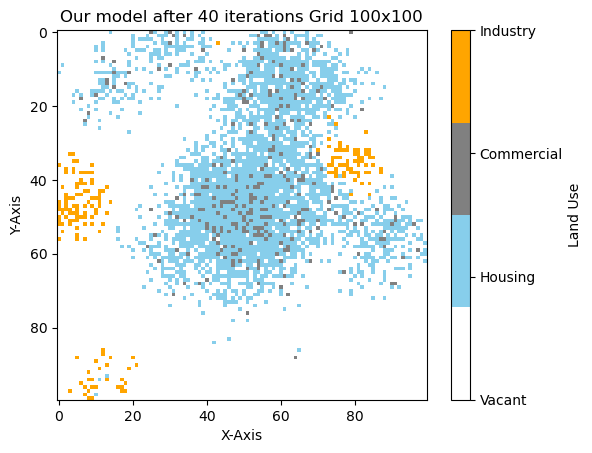

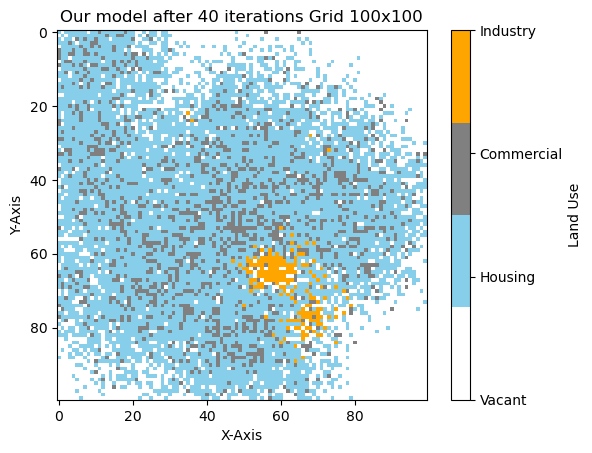

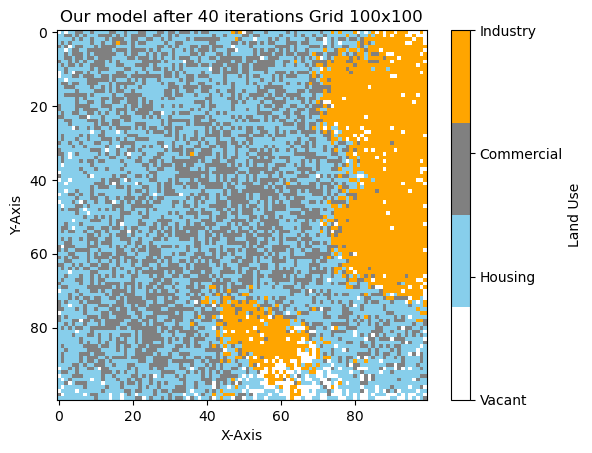

In [4]:

time = 40
grid_size = 100
cust_cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])


solution_dev = simulate_CA_city(grid_size,time,alpha = 1.5, amplify_c=5, amplify_i=200)
base_sol_plot = plt.imshow(solution_dev[time-1,:,:,0], vmin = 0, vmax = 3, cmap = cust_cmap)
cbar = plt.colorbar(ticks=[0,1,2, 3], label='Land Use')
cbar.set_ticklabels(['Vacant','Housing','Commercial', 'Industry'])
plt.title("Our model after 40 iterations Grid 100x100")
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.savefig('Alex_sim_res/cluster_base1.5.png')
plt.show()
            
solution_dev = simulate_CA_city(grid_size,time,alpha = 2.2, amplify_c=5, amplify_i=200)
base_sol_plot = plt.imshow(solution_dev[time-1,:,:,0], vmin = 0, vmax = 3, cmap = cust_cmap)
cbar = plt.colorbar(ticks=[0,1,2, 3], label='Land Use')
cbar.set_ticklabels(['Vacant','Housing','Commercial', 'Industry'])
plt.title("Our model after 40 iterations Grid 100x100")
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.savefig('Alex_sim_res/cluster_base2.2.png')
plt.show()
            
solution_dev = simulate_CA_city(grid_size,time,alpha = 3, amplify_c=5, amplify_i=200)
base_sol_plot = plt.imshow(solution_dev[time-1,:,:,0], vmin = 0, vmax = 3, cmap = cust_cmap)
cbar = plt.colorbar(ticks=[0,1,2, 3], label='Land Use')
cbar.set_ticklabels(['Vacant','Housing','Commercial', 'Industry'])
plt.title("Our model after 40 iterations Grid 100x100")
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.savefig('Alex_sim_res/cluster_base3.0.png')
plt.show()

In [ ]:
#Code for Gray Scott Phase diagramm
time = 25
grid_size = 75
simulation_grid_repeats = 4
alpha_start = 0
alpha_stop = 4
alpha_step = (alpha_stop-alpha_start)/(simulation_grid_repeats-1)
simulation_results_grid = np.zeros((simulation_grid_repeats,simulation_grid_repeats,grid_size,grid_size)).astype(np.int8)
#loop over 2^x scale for commercial growth rate 0.25-256
growth_arr = np.arange(-1,4,5/simulation_grid_repeats)
for i in range(simulation_grid_repeats):
    c_growth = 2**growth_arr[i]
    print(c_growth)
    #Loop over  alpha from 0.0 to 3.0 in 0.333 steps
    for j,loc_alpha in enumerate(np.arange(alpha_start,alpha_stop+0.01,alpha_step)):
        simulation_results_grid[i][j] = simulate_CA_city(grid_size,time,alpha = loc_alpha, amplify_c=c_growth)[time-1,:,:,0]
        with open('Alex_sim_res/alpha_%.2f' % loc_alpha +'_c_growth_%.2f' % c_growth+'v3.csv', 'w',encoding="utf8") as f:
            writer = csv.writer(f)
            for row in simulation_results_grid[i][j]:
                rowhandle = ','.join(str(int(x)) for x in row)
                writer.writerow(rowhandle)

In [ ]:
#Code for Gray Scott Phase diagramm
time = 25
grid_size = 75
simulation_grid_repeats = 25
alpha_start = 0
alpha_stop = 4
alpha_step = (alpha_stop-alpha_start)/(simulation_grid_repeats-1)
#loop over 2^x scale for commercial growth rate 0.25-256
#"""
growth_arr = np.arange(-1,4,5/simulation_grid_repeats)
simulation_results_grid = np.zeros((simulation_grid_repeats,simulation_grid_repeats,grid_size,grid_size)).astype(np.int8)
print(np.shape(simulation_results_grid))
for i in range(simulation_grid_repeats):
    c_growth = 2**growth_arr[i]
    #Loop over  alpha from 0.0 to 3.0 in 0.333 steps
    for j,loc_alpha in enumerate(np.arange(alpha_start,alpha_stop+0.01,alpha_step)):
        with open('Alex_sim_res/alpha_%.2f' % loc_alpha +'_c_growth_%.2f' % c_growth+'v3.csv', 'r',encoding="utf8") as f:
            data_raw = list(csv.reader(f))
            data = np.empty((grid_size,grid_size))
            reduce = 0
            for k,row in enumerate(data_raw):
                if row != []:
                    data[k-reduce] = list(filter(lambda character: character != ',', row))
                else:
                    reduce +=1
            simulation_results_grid[i,j,:,:]= data
#"""

In [ ]:
"""
#version using sumulation_results_grid
#Code for Gray Scott Phase diagramm
time = 25
grid_size = 75
simulation_grid_repeats = 25
alpha_start = 0
alpha_stop = 4
alpha_step = (alpha_stop-alpha_start)/(simulation_grid_repeats-1)
#simulation_results_grid = np.zeros((simulation_grid_repeats,simulation_grid_repeats,grid_size,grid_size)).astype(np.int8)
#loop over 2^x scale for commercial growth rate 0.25-256

heat_map_probabilistic_1 = np.zeros((simulation_grid_repeats,simulation_grid_repeats))
heat_map_probabilistic_2 = np.zeros((simulation_grid_repeats,simulation_grid_repeats))
heat_map_probabilistic_3 = np.zeros((simulation_grid_repeats,simulation_grid_repeats))

#"""
"""

for i in range(simulation_grid_repeats):
    for j in range(simulation_grid_repeats):
        if (simulation_results_grid[i][j]==0).all():
            heat_map_probabilistic_1[i][j] = 0
            heat_map_probabilistic_2[i][j] = 0
            heat_map_probabilistic_3[i][j] = 0
        elif(simulation_results_grid[i][j]==1).all():
            heat_map_probabilistic_1[i][j] = 10
            heat_map_probabilistic_2[i][j] = 0
            heat_map_probabilistic_3[i][j] = 0
        elif(simulation_results_grid[i][j]==2).all() :
            heat_map_probabilistic_1[i][j] = 0
            heat_map_probabilistic_2[i][j] = 10
            heat_map_probabilistic_3[i][j] = 0
        elif(simulation_results_grid[i][j]==3).all():
            heat_map_probabilistic_1[i][j] = 0
            heat_map_probabilistic_2[i][j] = 0
            heat_map_probabilistic_3[i][j] = 10
        else:
            wrk = run_clustering( simulation_results_grid[i][j])
            if len(wrk.Cluster_size[wrk.cell_type==1]) !=0:
                heat_map_probabilistic_1[i][j] = math.log(max(wrk.Cluster_size[wrk.cell_type==1]))
            else:
                heat_map_probabilistic_1[i][j] = 0
            if len(wrk.Cluster_size[wrk.cell_type==2]) !=0:
                heat_map_probabilistic_2[i][j] = math.log(max(wrk.Cluster_size[wrk.cell_type==2]))
            else:
                heat_map_probabilistic_2[i][j] = 0
            if len(wrk.Cluster_size[wrk.cell_type==3]) !=0:
                heat_map_probabilistic_3[i][j] = math.log(max(wrk.Cluster_size[wrk.cell_type==3]))
            else:
                heat_map_probabilistic_3[i][j] = 0
#"""

In [ ]:
#version using sumulation_results_grid
#Code for Gray Scott Phase diagramm
time = 25
grid_size = 75
simulation_grid_repeats = 25
alpha_start = 0
alpha_stop = 4
alpha_step = (alpha_stop-alpha_start)/(simulation_grid_repeats-1)
#simulation_results_grid = np.zeros((simulation_grid_repeats,simulation_grid_repeats,grid_size,grid_size)).astype(np.int8)
#loop over 2^x scale for commercial growth rate 0.25-256

heat_map_fr_dim_probabilistic = np.zeros((simulation_grid_repeats,simulation_grid_repeats,2))
heat_map_cond_ent_probabilistic = np.zeros((simulation_grid_repeats,simulation_grid_repeats))
#"""

for i in range(simulation_grid_repeats):
    for j in range(simulation_grid_repeats):
            heat_map_fr_dim_probabilistic[i][j] = fractal_dimension( simulation_results_grid[i][j])[0]
            heat_map_cond_ent_probabilistic[i][j] = conditional_entropy( simulation_results_grid[i][j])


In [ ]:
conditional_entropy( simulation_results_grid[1][1])

In [ ]:
list(range(simulation_grid_repeats))[::5]

In [ ]:
time = 25
grid_size = 75
simulation_grid_repeats = 25
alpha_start = 0
alpha_stop = 4
alpha_step = (alpha_stop-alpha_start)/(simulation_grid_repeats-1)
growth_arr = np.arange(-1,4,5/simulation_grid_repeats)


fr_dim_plt = plt.imshow(heat_map_fr_dim_probabilistic[:,:,0])
plt.title("Fractal Dimension")
plt.xlabel("alpha")
plt.xticks(list(range(simulation_grid_repeats))[::5], ['%.2f' % alph for alph in np.arange(alpha_start,alpha_stop+0.01,alpha_step)][::5])
plt.ylabel("Comm. growth")
plt.yticks(list(range(simulation_grid_repeats)), ['%.2f' % 2**i for i in growth_arr])
plt.colorbar(fr_dim_plt)
plt.savefig('Alex_sim_res/res_frac_dim.png')
plt.show()
#"""
fr_dim_plt2 = plt.imshow(heat_map_fr_dim_probabilistic[:,:,1])
plt.title("Fractal Dimension")
plt.xlabel("alpha")
plt.xticks(list(range(simulation_grid_repeats))[::5], ['%.2f' % alph for alph in np.arange(alpha_start,alpha_stop+0.01,alpha_step)][::5])
plt.ylabel("Comm. growth")
plt.yticks(list(range(simulation_grid_repeats)), ['%.2f' % 2**i for i in growth_arr])
plt.colorbar(fr_dim_plt2)
plt.savefig('Alex_sim_res/res_frac_dim2.png')
plt.show()

cond_ent_plt = plt.imshow(heat_map_cond_ent_probabilistic)
plt.title("Conditional Entropy")
plt.xlabel("alpha")
plt.xticks(list(range(simulation_grid_repeats))[::5], ['%.2f' % alph for alph in np.arange(alpha_start,alpha_stop+0.01,alpha_step)][::5])
plt.ylabel("Comm. growth")
plt.yticks(list(range(simulation_grid_repeats)), ['%.2f' % 2**i for i in growth_arr])
plt.colorbar(cond_ent_plt)
plt.savefig('Alex_sim_res/res_cond_ent.png')
plt.show()
#"""

In [ ]:
test_repeats = 5
simulation_results = np.zeros((test_repeats,100,100)).astype(np.int8)
for i in range(test_repeats):
    solution_dev = simulate_CA_city(100,20)
    simulation_results[i] = solution_dev[19,:,:,0]
    
np.save("simulation_results.npy",simulation_results)
#loadtry = np.load("simulation_results.npy")


In [ ]:
 merge_count = []
merge_size = []

for sim_res in loadtry:
    #sim_res = loadtry[1]


    wrk = run_clustering( sim_res)
    wrk_count = wrk.Cluster_count[wrk.cell_type == 1]
    wrk_size = wrk.Cluster_size[wrk.cell_type == 1]


    for i, size in enumerate(wrk_size):
        if size in merge_size:
            merge_count[merge_size==size] += wrk_count[i]
        else:
            merge_count = np.append(merge_count,wrk_count[i])
            merge_size = np.append(merge_size,size)

In [ ]:
r = np.arange(1,30)
plt.scatter(merge_size, merge_count/len(loadtry))
#plt.plot(r, power_law(r, pars[0], pars[1]), c= 'grey')

plt.yscale('log'), plt.xscale('log')
plt.show()